<a href="https://colab.research.google.com/github/JamesHorrex/AI_stock_trading/blob/master/SS_AITrader_MRK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.2.0


In [3]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-u1gg8kd7
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-u1gg8kd7
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.087622f0d4888b557639c605c04a0e822874df5ba_-cp36-none-any.whl size=123835 sha256=6bd4575d9ab5558f18a03de08bb32ffe50026b9f6c5c612e189fbdd90ce56612
  Stored in directory: /tmp/pip-ephem-wheel-cache-boryl4mq/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [5]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [361]:
import pandas as pd 
stock='MRK'
df=pd.read_csv('gdrive/My Drive/SS_AITrader/'+stock+'/df_'+stock+'_20drtn_features.csv')

In [362]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
0,2008-03-06,11.677793,26.610465,35.445346,28.334963,-98.264684,-98.648682,-98.648682,-99.576057,8.336545,20.400147,39.730985,25.485069,-1.988441,-3.790290,-6.216817,-8.107526,-7.263180,-0.454792,-0.535048,-0.542240,-0.275986,-1.836419,-1.836419,-1.836419,-1.836419,-121.175404,-123.842266,-146.624130,-199.393746,-107.122049,-120.582003,0.082472,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.173075,-0.020998,0.244899,-0.034358,0.320751,-0.017503,27.549999,2.949999,4.019999,-8.878482e+06,-8.878482e+06,-8.878482e+06,-8.878482e+06,-0.222352,-0.211977,-0.120590,0.019555,-0.106337,2.257,0.044,0.397,-0.480003,-0.720001,0.0
1,2008-03-07,12.221817,15.760495,34.367533,24.233596,-95.740747,-96.572287,-96.572287,-98.830114,8.234080,20.284305,33.313851,23.018455,-1.509789,-4.593232,-5.756206,-9.377034,-8.643328,-0.498258,-0.541628,-0.544849,-0.283319,-1.933714,-1.933714,-1.933714,-1.933714,-112.739018,-124.895619,-142.636175,-194.939267,-109.281399,-124.646570,0.155405,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.171152,-0.032500,0.247811,-0.039497,0.315917,-0.023732,27.490000,-0.059999,0.949999,-9.199881e+06,-9.199881e+06,-9.199881e+06,-9.199881e+06,-0.318679,-0.212743,-0.145858,-0.006505,-0.001921,2.141,-0.116,0.392,0.029999,-0.680000,0.0
2,2008-03-10,11.420527,16.119384,33.142599,22.043080,-96.075094,-96.805562,-96.805562,-98.858563,0.000000,12.576454,33.601023,20.959595,-1.173657,-4.601160,-6.354977,-11.818770,-7.343365,-0.546515,-0.552581,-0.549540,-0.290803,-2.026995,-2.026995,-2.026995,-2.026995,-116.090693,-129.853607,-142.717000,-192.285206,-113.461584,-130.584755,0.261363,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.096332,-0.077805,0.236713,-0.050869,0.315212,-0.024165,29.379999,1.889999,3.099998,-8.152322e+06,-8.152322e+06,-8.152322e+06,-8.152322e+06,-0.409535,-0.274467,-0.136257,-0.022165,-0.196213,2.138,-0.003,0.239,-0.040001,-0.709999,0.0
3,2008-03-11,17.558402,20.978702,41.818913,24.458478,-75.239919,-79.748817,-82.083323,-93.156495,10.930056,13.185241,34.426659,21.221841,2.569078,-0.165133,-3.290673,-8.773442,-6.598988,-0.576709,-0.560854,-0.553480,-0.298127,-1.992420,-1.992420,-1.992420,-1.992420,-40.572787,-85.805430,-105.498964,-146.666014,-114.506356,-133.589530,0.953124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.215325,0.041598,0.247942,-0.009577,0.326267,-0.013079,26.360001,-3.019999,0.840000,4.150188e+05,4.150188e+05,4.150188e+05,4.150188e+05,-0.261980,-0.144114,-0.113780,-0.001664,0.339333,2.156,0.018,0.172,0.290001,-0.380005,0.0
4,2008-03-12,19.014238,22.715388,38.557011,24.514132,-68.859615,-77.707985,-80.277752,-92.353247,21.652856,20.463145,32.915776,23.156668,0.307186,1.676649,-1.849709,-6.580101,-8.768532,-0.589460,-0.565476,-0.556136,-0.305213,-1.932255,-1.932255,-1.932255,-1.932255,88.812428,-28.932435,-63.197380,-99.927627,-115.664250,-136.148405,0.195652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.212790,0.041440,0.222541,-0.014883,0.327418,-0.005920,27.219999,0.859999,2.619999,9.548687e+05,9.548687e+05,9.548687e+05,9.548687e+05,-0.253173,-0.247603,-0.171131,-0.029677,-0.054716,2.043,-0.113,-0.170,-0.879997,-1.080002,0.0


In [363]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [364]:
from_date='2010-01-01'
to_date='2020-01-01'

In [365]:
df = df[pd.to_datetime(from_date) < df['timestamp'] ]
df = df[pd.to_datetime(to_date) > df['timestamp'] ]


In [366]:
df.head()

,timestamp,rsi_10,rsi_15,rsi_20,rsi_40,wr_10,wr_15,wr_20,wr_40,mfi_10,mfi_15,mfi_20,mfi_40,roc_1,roc_3,roc_5,roc_10,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_5,cci_10,cci_15,cci_25,kst_20,kst_40,ibr,bb_h10,bb_l10,bb_h15,bb_l15,bb_h20,bb_l20,bb_h40,bb_l40,realised_vol_10,realised_vol_change_5d_10,realised_vol_20,realised_vol_change_5d_20,realised_vol_40,realised_vol_change_5d_40,vix_level,vix_1d_change,vix_5d_change,forcei_10,forcei_15,forcei_20,forcei_40,cmf_10,cmf_15,cmf_20,cmf_40,volume_delta,curve,curve_shift,curve_shift_5d,dollarix_1d_change,dollarix_5d_change,labels
445,2010-01-05,48.228591,46.329680,52.997139,66.529875,-65.624975,-65.624975,-54.310280,-20.322564,55.131932,65.395923,60.119500,66.272610,0.405300,0.269829,-0.348622,-0.641716,1.253403,0.083406,0.242288,0.298182,0.254169,0.380283,0.380283,0.380283,0.380283,72.376101,-10.113186,-37.813428,6.916901,61.960297,76.980881,0.442306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.145376,-0.017789,0.170580,0.003154,0.189406,-0.058499,19.350000,-0.690001,-0.580000,1.510813e+06,1.510813e+06,1.510813e+06,1.510813e+06,-0.148697,-0.109427,-0.109707,0.039378,0.061044,3.695,-0.091,-0.092,0.090004,-0.009995,1.0
446,2010-01-06,54.730162,56.151688,56.959287,67.570215,-21.621608,-39.583284,-32.758553,-13.286690,55.246898,65.881207,64.508063,68.937561,1.345533,3.065131,1.509438,-0.079593,2.615801,0.073309,0.224986,0.286304,0.254055,0.396451,0.396451,0.396451,0.396451,124.833962,75.024995,20.066478,46.203730,55.761980,70.792078,0.915663,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.156915,0.028019,0.176456,0.007891,0.190232,-0.055239,19.160000,-0.190001,-0.850000,3.547192e+06,3.547192e+06,3.547192e+06,3.547192e+06,0.037677,-0.099404,-0.053418,0.058868,0.033578,3.763,0.068,0.049,-0.130005,-0.340004,0.0
447,2010-01-07,50.599827,49.482210,57.181909,68.259698,-12.857151,-36.458209,-30.172286,-12.589879,67.477904,65.709811,69.720742,68.228325,0.159324,1.918408,1.780895,-0.079467,3.768921,0.072486,0.211297,0.275647,0.253825,0.409387,0.409387,0.409387,0.409387,110.959817,156.315020,77.762184,85.615138,50.391877,64.904039,0.639999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.156915,0.035430,0.171707,0.015845,0.181579,-0.063808,19.059999,-0.100000,-0.900000,2.603132e+06,2.603132e+06,2.603132e+06,2.603132e+06,0.078153,-0.148001,0.001652,0.026395,-0.218066,3.777,0.014,0.033,0.420006,0.000000,0.0
448,2010-01-08,49.133173,46.412794,59.931809,66.134996,-14.285753,-37.499901,-37.499901,-12.949599,68.688261,58.998706,64.831304,66.259930,-0.053023,1.453178,3.174603,1.208056,1.480482,0.076037,0.200078,0.265869,0.253458,0.413261,0.413261,0.413261,0.413261,76.656102,130.795850,81.600528,78.476981,44.509307,58.888416,0.586959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.138891,0.005210,0.154486,-0.009341,0.181702,-0.061006,18.129999,-0.930000,-3.550001,1.663639e+06,1.663639e+06,1.663639e+06,1.663639e+06,0.180042,-0.124878,-0.049208,0.020300,-0.096462,3.768,-0.009,-0.025,-0.440002,-0.389999,0.0
449,2010-01-11,61.519288,51.346635,55.757187,66.070478,-4.929562,-29.687512,-29.687512,-10.251798,75.335484,67.137344,64.143234,68.526394,0.397872,0.504510,2.269657,2.324944,0.825779,0.083631,0.191396,0.257116,0.252995,0.423552,0.423552,0.423552,0.423552,75.034625,112.015194,90.796729,87.311443,41.708874,55.972649,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.131435,-0.013251,0.150735,-0.019592,0.177811,-0.011604,17.549999,-0.580000,-2.490002,1.588175e+06,1.588175e+06,1.588175e+06,1.588175e+06,0.220661,-0.001902,-0.000729,0.050338,-0.110085,3.793,0.025,0.007,-0.470001,-0.529999,0.0


In [367]:
df.drop(['timestamp'], inplace=True, axis=1)

In [368]:
train_dataset = df.sample(frac=0.8,random_state=0)
test_dataset = df.drop(train_dataset.index)

In [369]:
train_labels = train_dataset.pop('labels')
test_labels = test_dataset.pop('labels')

In [370]:
train_labels.head()

1856    1.0
2747    1.0
898     0.0
765     1.0
1100    1.0
Name: labels, dtype: float64

In [371]:
from sklearn.utils import compute_class_weight
def get_sample_weights(y):
      y = y.astype(int)  # compute_class_weight needs int labels
      class_weights = compute_class_weight('balanced', np.unique(y), y)

      print("real class weights are {}".format(class_weights), np.unique(y))
      print("value_counts", np.unique(y, return_counts=True))
      sample_weights = y.copy().astype(float)
      for i in np.unique(y):
          sample_weights[sample_weights == i] = class_weights[i]  # if i == 2 else 0.8 * class_weights[i]
            # sample_weights = np.where(sample_weights == i, class_weights[int(i)], y_)

      return sample_weights


In [372]:
get_sample_weights(train_labels)

real class weights are [1.16251483 0.87735004] [0 1]
value_counts (array([0, 1]), array([ 843, 1117]))


1856    0.877350
2747    0.877350
898     1.162515
765     0.877350
1100    0.877350
          ...   
2051    0.877350
1301    0.877350
2192    1.162515
1640    1.162515
2882    0.877350
Name: labels, Length: 1960, dtype: float64

In [373]:
SAMPLE_WEIGHT=get_sample_weights(train_labels)

real class weights are [1.16251483 0.87735004] [0 1]
value_counts (array([0, 1]), array([ 843, 1117]))


In [374]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()

In [375]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [376]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from operator import itemgetter

k=20
list_features = list(normed_train_data.columns)
select_k_best = SelectKBest(f_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_anova = itemgetter(*select_k_best.get_support(indices=True))(list_features)

selected_features_anova

('rsi_15',
 'rsi_20',
 'rsi_40',
 'wr_20',
 'wr_40',
 'mfi_15',
 'mfi_20',
 'mfi_40',
 'roc_20',
 'trix_10',
 'trix_15',
 'trix_20',
 'macd10',
 'macd15',
 'macd20',
 'macd40',
 'cci_25',
 'kst_20',
 'kst_40',
 'curve')

In [377]:
select_k_best = SelectKBest(mutual_info_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)
selected_features_mic

('rsi_15',
 'rsi_40',
 'roc_1',
 'roc_20',
 'trix_10',
 'trix_15',
 'trix_20',
 'trix_40',
 'macd10',
 'macd15',
 'macd20',
 'macd40',
 'cci_25',
 'kst_20',
 'kst_40',
 'realised_vol_20',
 'realised_vol_40',
 'vix_5d_change',
 'cmf_40',
 'curve')

In [378]:
list_features = list(normed_train_data.columns)
feat_idx = []
for c in selected_features_mic:
      feat_idx.append(list_features.index(c))

feat_idx = sorted(feat_idx)
X_train_new=normed_train_data.iloc[:, feat_idx]
X_test_new=normed_test_data.iloc[:, feat_idx]
#kbest=SelectKBest(f_classif, k=10)
#X_train_new = kbest.fit_transform(normed_train_data, train_labels)
#X_test_new = kbest.transform(normed_test_data)

X_test_new.shape
X_test_new.head()

,rsi_15,rsi_40,roc_1,roc_20,trix_10,trix_15,trix_20,trix_40,macd10,macd15,macd20,macd40,cci_25,kst_20,kst_40,realised_vol_20,realised_vol_40,vix_5d_change,cmf_40,curve
445,-0.450015,1.607678,0.310561,0.084069,0.225967,1.310779,1.984222,2.445432,0.386893,0.386893,0.386893,0.386893,-0.089555,1.285662,1.581568,-0.171365,0.049577,-0.194993,0.325769,2.013397
448,-0.444466,1.563129,-0.067004,0.131342,0.189580,1.043611,1.740410,2.437380,0.441285,0.441285,0.441285,0.441285,0.554723,0.860018,1.153755,-0.413634,-0.098099,-1.176824,0.160890,2.093196
452,1.109191,2.306945,2.219743,0.913333,0.597493,0.984354,1.564598,2.421551,0.816965,0.816965,0.816965,0.816965,3.042213,0.701236,0.969301,0.353757,0.265399,-0.475989,1.053170,2.006838
469,-1.274811,-0.462289,-0.293492,-0.935870,-0.779131,0.270677,0.964075,2.306374,-0.567826,-0.567826,-0.567826,-0.567826,-1.260416,0.123775,0.136914,2.283860,1.328342,1.490979,-0.426129,1.836308
470,-1.944665,-0.664167,-0.633210,-0.925302,-1.076024,0.038669,0.792678,2.249123,-0.747217,-0.747217,-0.747217,-0.747217,-1.459089,-0.119227,-0.102466,2.281974,1.304954,1.252959,-0.395540,1.902990


In [380]:
def build_model(hidden_dim,dropout=0.5):
    ## input layer
    inputs=tf.keras.Input(shape=(X_train_new.shape[1],))


    h1= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(inputs)
    h2= tf.keras.layers.Dropout(dropout)(h1)
    h3= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h2)
    h4= tf.keras.layers.Dropout(dropout)(h3)
    h5= tf.keras.layers.Dense(units=hidden_dim*2,activation='relu')(h4)
    h6= tf.keras.layers.Dropout(dropout)(h5)
    h7= tf.keras.layers.Dense(units=hidden_dim,activation='relu')(h6)

    ##output
    outputs=tf.keras.layers.Dense(units=2,activation='softmax')(h7)

    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [381]:
tf.random.set_seed(1)

criterion = tf.keras.losses.sparse_categorical_crossentropy

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model = build_model(hidden_dim=64)

model.compile(optimizer=optimizer,loss=criterion,metrics=['accuracy'])

In [382]:
example_batch = X_train_new[:10]
example_result = model.predict(example_batch)
example_result

array([[0.5753907 , 0.42460927],
       [0.54730994, 0.45269006],
       [0.56634927, 0.43365076],
       [0.5715948 , 0.42840526],
       [0.4886788 , 0.5113211 ],
       [0.5279631 , 0.4720369 ],
       [0.5980535 , 0.40194649],
       [0.5214368 , 0.4785632 ],
       [0.5961742 , 0.40382585],
       [0.5691063 , 0.43089372]], dtype=float32)

In [383]:
EPOCHS=200
BATCH_SIZE=20

history = model.fit(
  X_train_new, train_labels,
  epochs=EPOCHS, batch_size=BATCH_SIZE ,sample_weight=SAMPLE_WEIGHT,shuffle=True,validation_split = 0.2, verbose=1,
  callbacks=[tfdocs.modeling.EpochDots()])

Epoch 1/200
73/79 [==========================>...] - ETA: 0s - loss: 0.7098 - accuracy: 0.5212
Epoch: 0, accuracy:0.5223,  loss:0.7083,  val_accuracy:0.6556,  val_loss:0.6656,  
79/79 [==============================] - 1s 7ms/step - loss: 0.7083 - accuracy: 0.5223 - val_loss: 0.6656 - val_accuracy: 0.6556
Epoch 2/200
79/79 [==============================] - 0s 5ms/step - loss: 0.7033 - accuracy: 0.5472 - val_loss: 0.6654 - val_accuracy: 0.6786
Epoch 3/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6846 - accuracy: 0.5663 - val_loss: 0.6618 - val_accuracy: 0.6837
Epoch 4/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6798 - accuracy: 0.5676 - val_loss: 0.6496 - val_accuracy: 0.6786
Epoch 5/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6738 - accuracy: 0.5918 - val_loss: 0.6411 - val_accuracy: 0.6811
Epoch 6/200
79/79 [==============================] - 0s 5ms/step - loss: 0.6712 - accuracy: 0.5886 - val_loss: 0.6327 - val_accur

In [384]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
195,0.389142,0.826531,0.378292,0.811224,195
196,0.391982,0.822066,0.378319,0.818878,196
197,0.409905,0.809949,0.385219,0.823980,197
198,0.391841,0.820153,0.371551,0.846939,198
199,0.413612,0.806760,0.379967,0.831633,199


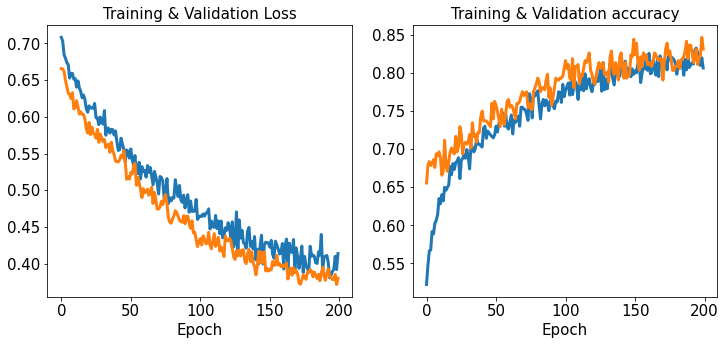

In [385]:
import matplotlib.pyplot as plt

hist=history.history

fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.plot(hist['loss'],lw=3)
ax.plot(hist['val_loss'],lw=3)
ax.set_title('Training & Validation Loss',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax=fig.add_subplot(1,2,2)
ax.plot(hist['accuracy'],lw=3)
ax.plot(hist['val_accuracy'],lw=3)
ax.set_title('Training & Validation accuracy',size=15)
ax.set_xlabel('Epoch',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
plt.show()




In [32]:
!pip install shap

     |████████████████████████████████| 276kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394130 sha256=fa7a3695c4152743202e7de8bd95b7d76cec14ad3ea03f3ef255b7369251cec7
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [386]:
import shap

explainer = shap.DeepExplainer(model, np.array(X_train_new))

In [387]:
shap_values  = explainer.shap_values(np.array(X_test_new))

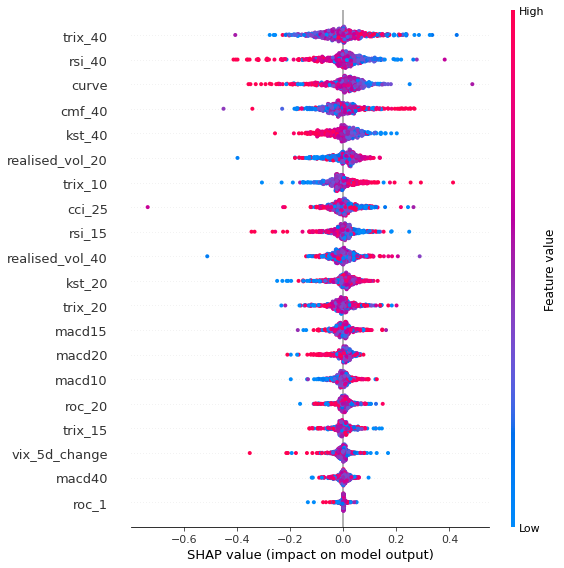

In [388]:
shap.summary_plot(shap_values[1], X_test_new)

In [389]:
pred=model.predict(X_test_new)
pred.argmax(axis=1)

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,

In [390]:
from sklearn.metrics import classification_report, confusion_matrix

cm=confusion_matrix(test_labels, pred.argmax(axis=1))

Confusion Matrix


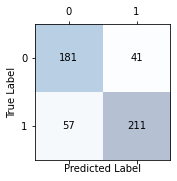

In [391]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [392]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('Recall: %.3f' % recall_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

print('F1: %.3f' % f1_score(y_true=test_labels,y_pred=pred.argmax(axis=1)))

Precision: 0.837
Recall: 0.787
F1: 0.812


In [393]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
import xgboost as xgb
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer

In [394]:
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic'))
])

In [395]:
search_space = [
  {
    'clf__n_estimators': [200],
    'clf__learning_rate': [0.05, 0.5, 0.1],
    'clf__max_depth': range(3, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [mutual_info_classif,f_classif],
    'fs__k': [30,40],
  }
]

In [396]:
kfold = KFold(n_splits=4, shuffle=True, random_state=42)

In [397]:
scoring = {'AUC':'roc_auc', 'Accuracy':make_scorer(accuracy_score)}

In [398]:
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

In [399]:
model = grid.fit(normed_train_data, train_labels)

Fitting 4 folds for each of 504 candidates, totalling 2016 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed: 17.4min
[Parallel(n_jobs=-1)]: Done 2016 out of 2016 | elapsed: 19.7min finished


In [400]:
import pickle

# Dictionary of best parameters
best_pars = grid.best_params_
# Best XGB model that was found based on the metric score you specify
best_model = grid.best_estimator_
# Save model
pickle.dump(grid.best_estimator_, open('gdrive/My Drive/SS_AITrader/'+stock+'/xgb_'+stock+'_log_reg.pickle', "wb"))

In [402]:
predict = model.predict(normed_test_data)
print('Best AUC Score: {}'.format(model.best_score_))
print('Accuracy: {}'.format(accuracy_score(test_labels, predict)))
cm=confusion_matrix(test_labels,predict)

Best AUC Score: 0.9331986320959006
Accuracy: 0.8734693877551021


Confusion Matrix


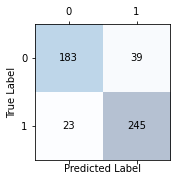

In [403]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [404]:
print(model.best_params_)

{'clf__colsample_bytree': 0.2, 'clf__gamma': 0.0, 'clf__learning_rate': 0.1, 'clf__max_depth': 9, 'clf__n_estimators': 200, 'fs__k': 40, 'fs__score_func': <function f_classif at 0x7f9d4726fd90>}


In [405]:
k=40
select_k_best = SelectKBest(f_classif, k=k)
select_k_best.fit(normed_train_data, train_labels)
selected_features_mic = itemgetter(*select_k_best.get_support(indices=True))(list_features)

list_features = list(normed_train_data.columns)
feat_idx = []
for c in selected_features_mic:
      feat_idx.append(list_features.index(c))

feat_idx = sorted(feat_idx)
X_train_new=normed_train_data.iloc[:, feat_idx]
X_test_new=normed_test_data.iloc[:, feat_idx]




In [406]:
model_opt = xgb.XGBClassifier(max_depth=9,
                        objective='binary:logistic',
                        n_estimators=200,
                        learning_rate = 0.1,
                        colsample_bytree= 0.2,
                        gamma= 0.0)
eval_set = [(X_train_new, train_labels), (X_test_new, test_labels)]
model_opt.fit(X_train_new, train_labels, early_stopping_rounds=15, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)

[0]	validation_0-error:0.245408	validation_0-logloss:0.66282	validation_1-error:0.377551	validation_1-logloss:0.679586
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 15 rounds.
[1]	validation_0-error:0.138265	validation_0-logloss:0.62787	validation_1-error:0.32449	validation_1-logloss:0.660771
[2]	validation_0-error:0.104592	validation_0-logloss:0.596401	validation_1-error:0.330612	validation_1-logloss:0.652343
[3]	validation_0-error:0.071429	validation_0-logloss:0.557086	validation_1-error:0.253061	validation_1-logloss:0.622557
[4]	validation_0-error:0.061735	validation_0-logloss:0.528802	validation_1-error:0.246939	validation_1-logloss:0.610308
[5]	validation_0-error:0.05102	validation_0-logloss:0.502803	validation_1-error:0.246939	validation_1-logloss:0.594649
[6]	validation_0-error:0.037755	validation_0-logloss:0.473912	validation_1-error:0.206122	validation_1-logloss:0.572227

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.2, gamma=0.0,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [407]:

# make predictions for test data
y_pred = model_opt.predict(X_test_new)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.35%


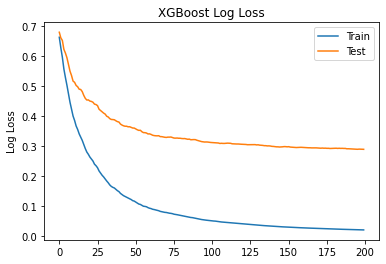

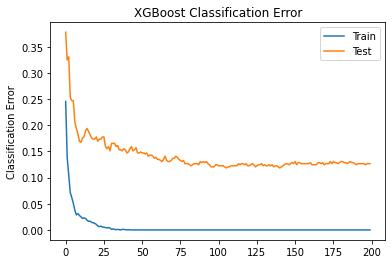

In [408]:
from matplotlib import pyplot

results = model_opt.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

In [409]:
shap_values = shap.TreeExplainer(model_opt).shap_values(X_test_new) 

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


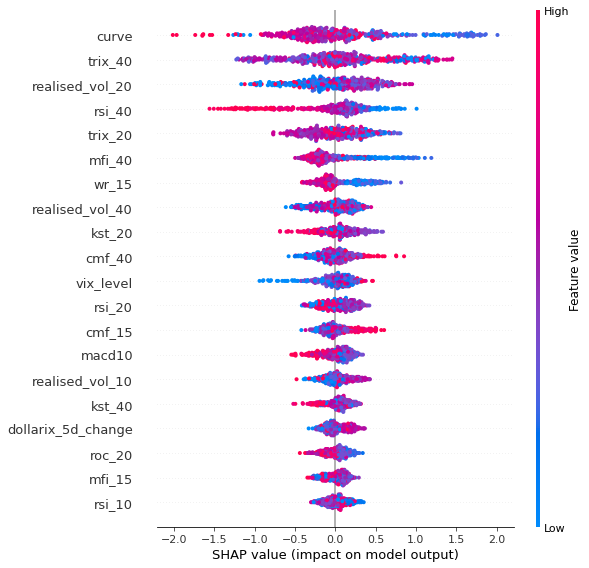

In [410]:
shap.summary_plot(shap_values, X_test_new)

In [411]:
predict = model_opt.predict(X_test_new)

cm=confusion_matrix(test_labels,predict)

Confusion Matrix


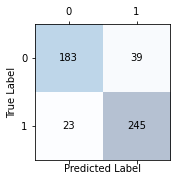

In [412]:
print('Confusion Matrix')
fig,ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(cm,cmap=plt.cm.Blues,alpha=0.3)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    ax.text(x=j,y=i,
            s=cm[i,j],
            va='center',ha='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()